<a href="https://colab.research.google.com/github/ianhstudent/ColabMLNotebook/blob/master/Bootstrap_ANN_Predict_20240813.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

import io
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.utils import compute_class_weight
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Upload the data file with observations

from google.colab import files
fn = files.upload()


Saving Term&Preterm_AllSamples_20240404.csv to Term&Preterm_AllSamples_20240404.csv


In [ ]:
import io

# Adjust to read the uploaded file (name should already be provided after the upload)
data = pd.read_csv(io.BytesIO(fn['Term&Preterm_AllSamples_20240404.csv']))

print(data)

     Group       Thymine  4-Aminohippuric acid  5-Aminopentanamide  \
0        0  16148.476140           8415.820791         6905.938406   
1        0  24901.941100           8256.863739        14832.413540   
2        0   7641.399579           3974.474322         8179.276112   
3        0  14861.731150           3597.318170         7409.747105   
4        0  24297.212620           1230.643149          999.343056   
..     ...           ...                   ...                 ...   
145      1  12481.279420           6060.336998        11573.555520   
146      1  10958.468430           4564.755171         2608.258373   
147      1   9084.021333           1522.630155         1265.233521   
148      1  29612.010220           3227.926086         1788.734921   
149      1  12011.645970           1581.129616         1996.768786   

     5-Hydroxyoctanoylcarnitine (C10:0-OH)  Acetylcarnitine  Acetylcholine  \
0                             542037.60150     18407.927030    66215.74512   
1  

In [ ]:
# Check the number of features in the data file

n_features = data.shape[1]
print(n_features)

182


In [ ]:
X = data.drop(columns=['Group'])  # All columns except 'Group'
y = data['Group']  # Replace with your target column

print(X)

          Thymine  4-Aminohippuric acid  5-Aminopentanamide  \
0    16148.476140           8415.820791         6905.938406   
1    24901.941100           8256.863739        14832.413540   
2     7641.399579           3974.474322         8179.276112   
3    14861.731150           3597.318170         7409.747105   
4    24297.212620           1230.643149          999.343056   
..            ...                   ...                 ...   
145  12481.279420           6060.336998        11573.555520   
146  10958.468430           4564.755171         2608.258373   
147   9084.021333           1522.630155         1265.233521   
148  29612.010220           3227.926086         1788.734921   
149  12011.645970           1581.129616         1996.768786   

     5-Hydroxyoctanoylcarnitine (C10:0-OH)  Acetylcarnitine  Acetylcholine  \
0                             542037.60150     18407.927030    66215.74512   
1                             705404.28280     27834.145230    58401.76965   
2        

In [ ]:
# Exclude features with over 50% missing values
missing_threshold = 0.5  # 50% threshold
X = X.loc[:, data.isna().mean() <= missing_threshold]

n_features = X.shape[1]
print(n_features)

175


In [ ]:
# Handle missing values in the remaining features using KNN imputation

imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors as needed
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)


In [ ]:
# Perform z-score normalization via a stand scaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

print(X_scaled)

[[ 0.28301548 -0.25640328 -0.25227175 ...  0.09403202  0.20351549
  -0.90407469]
 [ 1.6269845  -0.27395635  1.40909904 ... -0.09750252  1.31165686
  -0.54872333]
 [-1.02312414 -0.74684555  0.01461688 ... -0.8844403  -0.14631883
  -1.15568279]
 ...
 [-0.80163026 -1.01759407 -1.4345504  ... -1.02065451 -0.77471925
  -1.3305173 ]
 [ 2.35014808 -0.82928424 -1.32482572 ... -0.90865676 -0.57308639
  -1.04672183]
 [-0.35213547 -1.01113418 -1.28122231 ... -0.91131114 -0.80402271
  -0.98240467]]


Here we are done with chekcking data for missing values and remove the ones with too many missing values. We also performed log transformation of the data. Next we check on the target file to decide the approach to analyze each target variable.

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Set the number of bootstrap samples
n_iterations = 100

# Initialize lists to store sample fpr, tpr, and auc
sample_fpr = []
sample_tpr = []
sample_auc = []
mean_fpr = np.linspace(0, 1, 100)
tprs = []

# Initialize lists to store accuracy
sample_accuracy = []

# Convert 0 to False and 1 to True
y_train_bool = np.array(y_train, dtype=bool)

# Initialize arrays to store predicted probabilities
train_probas = np.zeros((n_iterations, X_train.shape[0]))
test_probas = np.zeros((n_iterations, X_test.shape[0]))

# Initialize lists to store the confusion matrices
confusion_matrices = []

In [ ]:
# Initialize arrays to store predicted probabilities
train_probas = np.zeros((n_iterations, X_train.shape[0]))
test_probas = np.zeros((n_iterations, X_test.shape[0]))


In [ ]:
# Interpolate the mean FPR
from scipy.interpolate import interp1d

# Perform bootstrap iterations on the full dataset (with cross-validation)
for i in range(n_iterations):
    # Bootstrap sample from the full dataset
    indices = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=True)
    X_train_boot = X_train[indices]
    y_train_boot = y_train_bool[indices]

    # Define and compile the model
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_dim=X_train_boot.shape[1]),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Compute class weights based on the bootstrapped training data
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_boot), y=y_train_boot)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Perform k-fold cross-validation on the bootstrap sample
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_index = 0

    for train_idx, test_idx in cv.split(X_train_boot, y_train_boot):
        X_train_fold, X_test_fold = X_train_boot[train_idx], X_train_boot[test_idx]
        y_train_fold, y_test_fold = y_train_boot[train_idx], y_train_boot[test_idx]

        # Reinitialize and fit the model on the fold's training data
        model = models.Sequential([
            layers.Dense(64, activation='relu', input_dim=X_train_fold.shape[1]),
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, verbose=0, class_weight=class_weights_dict)

        # Make predictions on the fold's validation data
        y_scores = model.predict(X_test_fold).flatten()

        # Round the predicted scores to get binary predictions
        y_pred = np.round(y_scores)

        # Calculate the confusion matrix and accuracy based on validation predictions
        cm = confusion_matrix(y_test_fold, y_pred)
        print(f'Bootstrap {i}, Fold {fold_index} - Confusion Matrix:\n{cm}')

        accuracy = accuracy_score(y_test_fold, y_pred)
        print(f'Bootstrap {i}, Fold {fold_index} - Validation Accuracy: {accuracy:.4f}')

        # Store results
        sample_accuracy.append(accuracy)
        confusion_matrices.append(cm)

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test_fold, y_scores)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

        # Calculate AUC
        roc_auc = auc(fpr, tpr)
        sample_auc.append(roc_auc)

        fold_index += 1

    # Store predictions for the entire dataset for this bootstrap iteration
    if i == 0:  # Initialize arrays on first iteration
        train_probas = np.zeros((n_iterations, X_train.shape[0]))

    train_probas[i] = model.predict(X_train)[:, 0]

# Final metrics aggregation (example: mean accuracy across all iterations)
mean_accuracy = np.mean(sample_accuracy)
mean_auc = np.mean(sample_auc)
print(f'Mean Validation Accuracy across all bootstraps and folds: {mean_accuracy:.4f}')
print(f'Mean AUC across all bootstraps and folds: {mean_auc:.4f}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Bootstrap 0, Fold 0 - Confusion Matrix:
[[ 7  1]
 [ 5 11]]
Bootstrap 0, Fold 0 - Validation Accuracy: 0.7500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Bootstrap 0, Fold 1 - Confusion Matrix:
[[ 4  4]
 [ 0 16]]
Bootstrap 0, Fold 1 - Validation Accuracy: 0.8333


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Bootstrap 0, Fold 2 - Confusion Matrix:
[[ 7  1]
 [ 1 15]]
Bootstrap 0, Fold 2 - Validation Accuracy: 0.9167


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Bootstrap 0, Fold 3 - Confusion Matrix:
[[ 4  4]
 [ 1 15]]
Bootstrap 0, Fold 3 - Validation Accuracy: 0.7917


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Bootstrap 0, Fold 4 - Confusion Matrix:
[[ 5  2]
 [ 2 15]]
Bootstrap 0, Fold 4 - Validation Accuracy: 0.8333
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Bootstrap 1, Fold 0 - Confusion Matrix:
[[ 4  7]
 [ 2 11]]
Bootstrap 1, Fold 0 - Validation Accuracy: 0.6250


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Bootstrap 1, Fold 1 - Confusion Matrix:
[[11  0]
 [ 3 10]]
Bootstrap 1, Fold 1 - Validation Accuracy: 0.8750


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Bootstrap 1, Fold 2 - Confusion Matrix:
[[8 3]
 [4 9]]
Bootstrap 1, Fold 2 - Validation Accuracy: 0.7083


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Bootstrap 1, Fold 3 - Confusion Matrix:
[[10  1]
 [ 2 11]]
Bootstrap 1, Fold 3 - Validation Accuracy: 0.8750


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Bootstrap 1, Fold 4 - Confusion Matrix:
[[ 9  2]
 [ 3 10]]
Bootstrap 1, Fold 4 - Validation Accuracy: 0.7917
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Bootstrap 2, Fold 0 - Confusion Matrix:
[[ 3  3]
 [ 2 16]]
Bootstrap 2, Fold 0 - Validation Accuracy: 0.7917


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Bootstrap 2, Fold 1 - Confusion Matrix:
[[ 2  4]
 [ 1 17]]
Bootstrap 2, Fold 1 - Validation Accuracy: 0.7917


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Bootstrap 2, Fold 2 - Confusion Matrix:
[[ 3  3]
 [ 3 15]]
Bootstrap 2, Fold 2 - Validation Accuracy: 0.7500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Bootstrap 2, Fold 3 - Confusion Matrix:
[[ 2  5]
 [ 5 12]]
Bootstrap 2, Fold 3 - Validation Accuracy: 0.5833


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Bootstrap 2, Fold 4 - Confusion Matrix:
[[ 1  6]
 [ 1 16]]
Bootstrap 2, Fold 4 - Validation Accuracy: 0.7083
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Bootstrap 3, Fold 0 - Confusion Matrix:
[[ 3  4]
 [ 1 16]]
Bootstrap 3, Fold 0 - Validation Accuracy: 0.7917


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Bootstrap 3, Fold 1 - Confusion Matrix:
[[ 5  2]
 [ 1 16]]
Bootstrap 3, Fold 1 - Validation Accuracy: 0.8750


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Bootstrap 3, Fold 2 - Confusion Matrix:
[[ 2  6]
 [ 5 11]]
Bootstrap 3, Fold 2 - Validation Accuracy: 0.5417


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Bootstrap 3, Fold 3 - Confusion Matrix:
[[ 6  2]
 [ 4 12]]
Bootstrap 3, Fold 3 - Validation Accuracy: 0.7500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Bootstrap 3, Fold 4 - Confusion Matrix:
[[ 5  3]
 [ 1 15]]
Bootstrap 3, Fold 4 - Validation Accuracy: 0.8333
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Bootstrap 4, Fold 0 - Confusion Matrix:
[[ 5  1]
 [ 0 18]]
Bootstrap 4, Fold 0 - Validation Accuracy: 0.9583


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Bootstrap 4, Fold 1 - Confusion Matrix:
[[ 5  1]
 [ 1 17]]
Bootstrap 4, Fold 1 - Validation Accuracy: 0.9167


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Bootstrap 4, Fold 2 - Confusion Matrix:
[[ 5  1]
 [ 4 14]]
Bootstrap 4, Fold 2 - Validation Accuracy: 0.7917


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Bootstrap 4, Fold 3 - Confusion Matrix:
[[ 5  2]
 [ 3 14]]
Bootstrap 4, Fold 3 - Validation Accuracy: 0.7917


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Bootstrap 4, Fold 4 - Confusion Matrix:
[[ 3  4]
 [ 2 15]]
Bootstrap 4, Fold 4 - Validation Accuracy: 0.7500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean Validation Accuracy across all bootstraps and folds: 0.7433
Mean AUC across all bootstraps and folds: 0.8102


In [ ]:
# Evaluate the model on the validation fold
val_loss, val_accuracy = model.evaluate(X_test_fold, y_test_fold, verbose=0)
print(f'Fold {fold_index} - Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}')

# Make predictions on the validation fold
y_scores = model.predict(X_test_fold).flatten()

# Round the predicted scores to get binary predictions
y_pred = np.round(y_scores)

# Calculate the confusion matrix based on the validation fold predictions
cm = confusion_matrix(y_test_fold, y_pred)
print(f'Fold {fold_index} - Confusion Matrix:\n{cm}')

confusion_matrices.append(cm)

Fold 5 - Validation Accuracy: 0.7500, Validation Loss: 0.4234
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Fold 5 - Confusion Matrix:
[[ 3  4]
 [ 2 15]]


In [ ]:
# Compute mean and standard deviation of the ROC
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)



# Calculate the mean and standard deviation of the auc and accuracy
mean_auc = np.mean(sample_auc)
std_auc = np.std(sample_auc)
mean_accuracy = np.mean(sample_accuracy)
std_accuracy = np.std(sample_accuracy)

# Calculate the confidence interval for AUC
alpha = 0.95
lower_auc = np.percentile(sample_auc, (1 - alpha) / 2 * 100)
upper_auc = np.percentile(sample_auc, (alpha + (1 - alpha) / 2) * 100)

lower_accuracy = np.percentile(sample_accuracy, (1 - alpha) / 2 * 100)
upper_accuracy = np.percentile(sample_accuracy, (alpha + (1 - alpha) / 2) * 100)



# Display the confidence interval for AUC and accuracy
print(f"Bootstrap Confidence Interval for AUC: {alpha*100}%")
print(f"Lower bound AUC: {lower_auc:.3f}")
print(f"Upper bound AUC: {upper_auc:.3f}")
print(f"Bootstrap Confidence Interval for Accuracy: {alpha*100}%")
print(f"Lower bound Accuracy: {lower_accuracy:.3f}")
print(f"Upper bound Accuracy: {upper_accuracy:.3f}")
print(f"Mean auc: {mean_auc:.3f}")
print(f"Mean Accuracy: {mean_accuracy:.3f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.3f}")

Bootstrap Confidence Interval for AUC: 95.0%
Lower bound AUC: 0.557
Upper bound AUC: 0.990
Bootstrap Confidence Interval for Accuracy: 95.0%
Lower bound Accuracy: 0.583
Upper bound Accuracy: 0.917
Mean auc: 0.810
Mean Accuracy: 0.743
Standard Deviation of Accuracy: 0.097


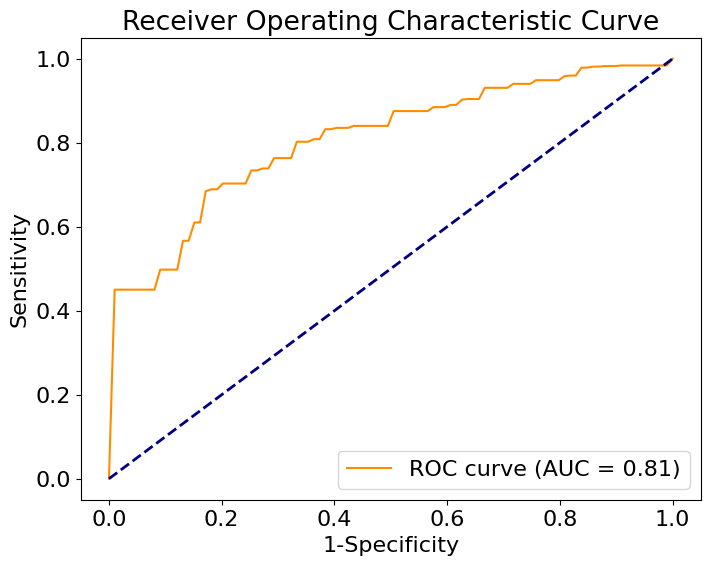

In [ ]:
# Plot the mean ROC curve
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

plt.plot(mean_fpr, mean_tpr, color='darkorange', label=f'ROC curve (AUC = {mean_auc:.2f})')

# Plot the confidence interval for the ROC curve using bootstrapped percentiles
percentiles = np.percentile(tprs, [(1 - alpha) / 2 * 100, (alpha + (1 - alpha) / 2) * 100], axis=0)
lower_tpr_percentile, upper_tpr_percentile = percentiles


plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)

# Add labels and legend
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

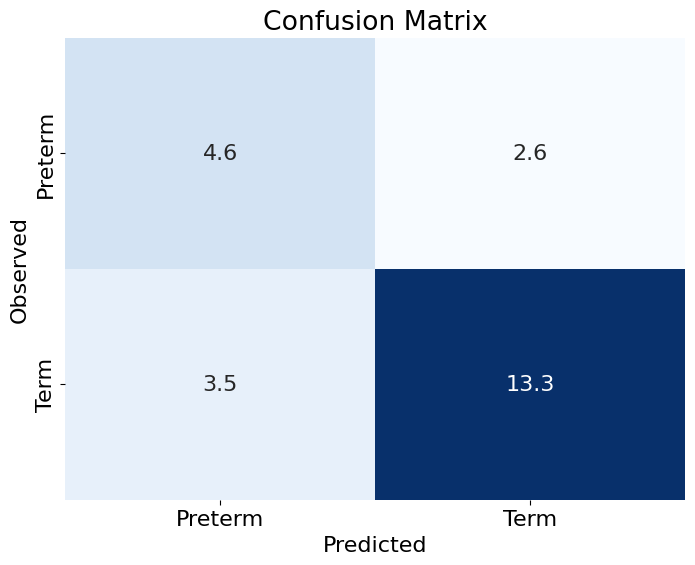

In [ ]:
# Compute the average confusion matrix
average_cm = np.mean(confusion_matrices, axis=0)

plt.figure(figsize=(8, 6))

plt.rcParams.update({'font.size': 16})  # Adjust font size as needed

sns.heatmap(average_cm, annot=True, fmt='.1f', cmap='Blues', cbar=False,
            xticklabels=["Preterm", "Term"], yticklabels=["Preterm", "Term"])
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.title('Confusion Matrix')
plt.savefig('ConfusionMatrix.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()

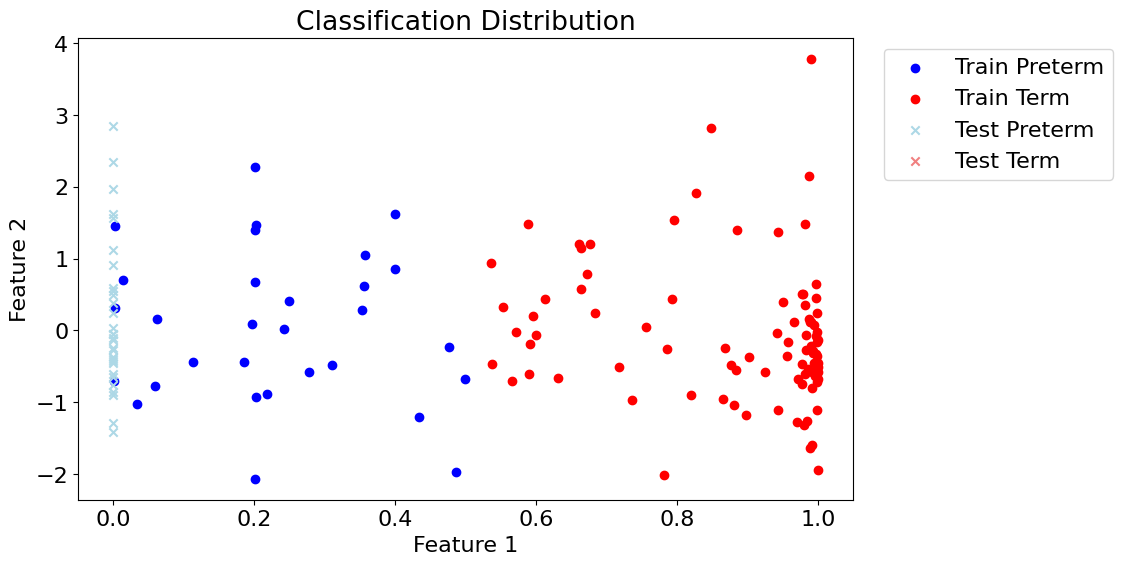

In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns

# Calculate average probabilities
avg_train_proba = np.mean(train_probas, axis=0)
avg_test_proba = np.mean(test_probas, axis=0)

# Predict classes using the average probabilities
y_train_pred_avg = np.round(avg_train_proba).astype(int)
y_test_pred_avg = np.round(avg_test_proba).astype(int)

# Create feature matrices including average predicted probabilities
X_train_cluster_avg = np.column_stack((avg_train_proba, X_train))  # Add average predicted probabilities as the first feature
X_test_cluster_avg = np.column_stack((avg_test_proba, X_test))

# Extract coordinates of data points for each class
train_class_0_points_avg = X_train_cluster_avg[y_train_pred_avg == 0]
train_class_1_points_avg = X_train_cluster_avg[y_train_pred_avg == 1]
test_class_0_points_avg = X_test_cluster_avg[y_test_pred_avg == 0]
test_class_1_points_avg = X_test_cluster_avg[y_test_pred_avg == 1]

# Plot data points

plt.figure(figsize=(10, 6))

plt.rcParams.update({'font.size': 16})  # Adjust font size as needed for all figures

plt.scatter(train_class_0_points_avg[:, 0], train_class_0_points_avg[:, 1], color='blue', label='Train Preterm')
plt.scatter(train_class_1_points_avg[:, 0], train_class_1_points_avg[:, 1], color='red', label='Train Term')
plt.scatter(test_class_0_points_avg[:, 0], test_class_0_points_avg[:, 1], color='lightblue', marker='x', label='Test Preterm')
plt.scatter(test_class_1_points_avg[:, 0], test_class_1_points_avg[:, 1], color='lightcoral', marker='x', label='Test Term')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Classification Distribution')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
plt.show()

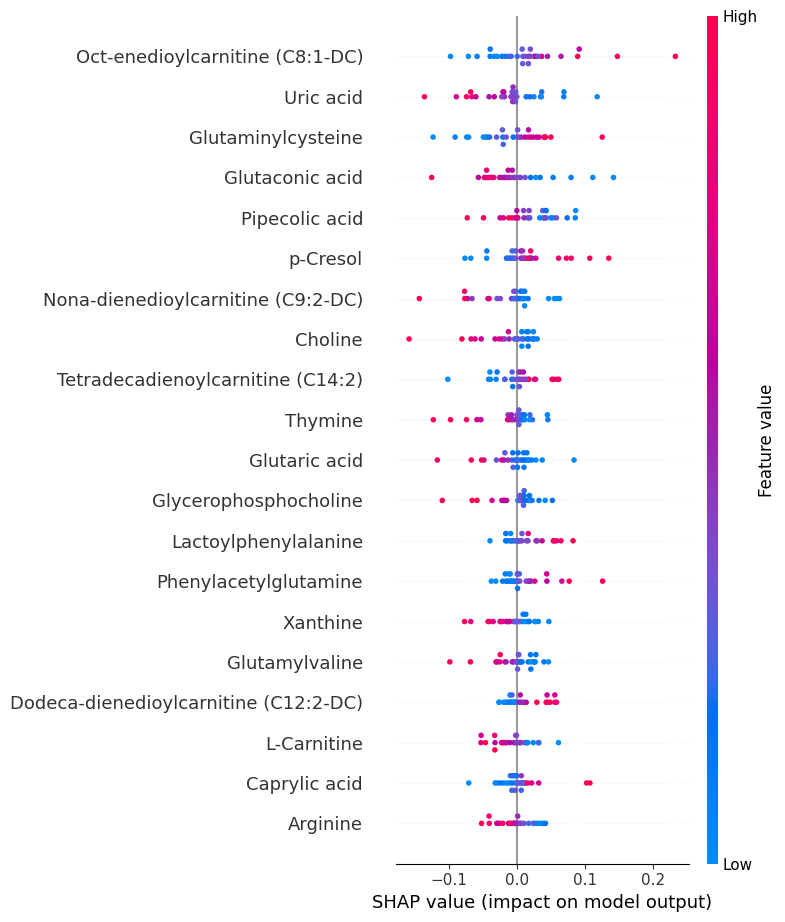

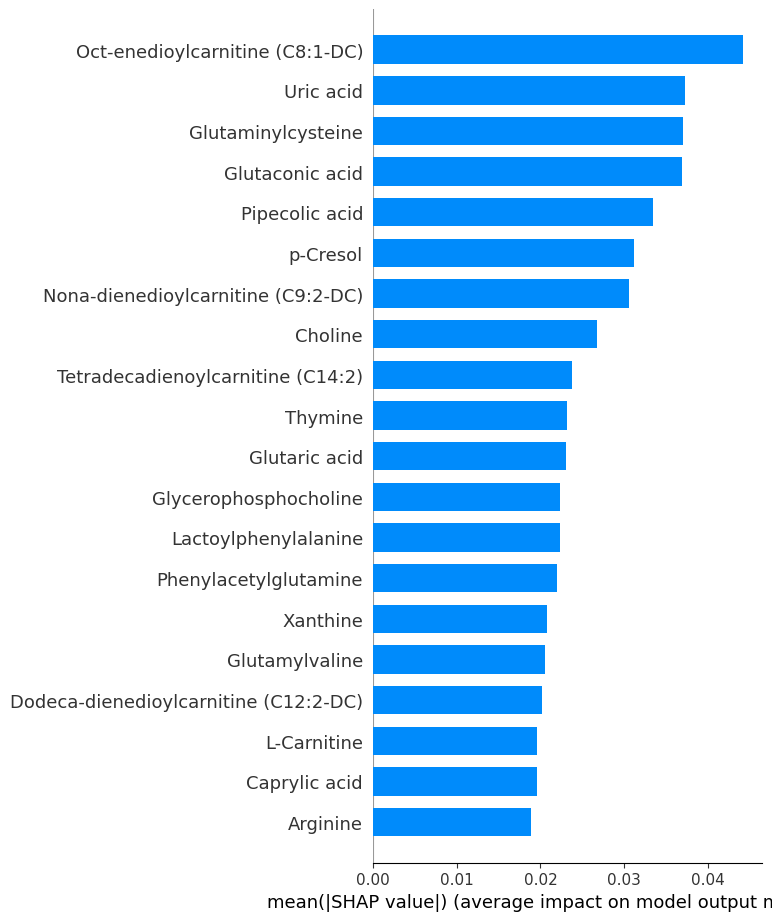

In [ ]:
#Shap evlauation of feature improtance

# Use SHAP to explain feature importances
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summarize the feature importance values
shap.summary_plot(shap_values, X_test, feature_names=X.columns)
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type='bar')